# Predict Adsorption Energies with Machine Learning

This notebook was created to facilitate our April 2021 webinar, which detailed the creation of a simple model of CO adsorption. The video can be found in the following link:

https://www.youtube.com/watch?v=wOrqnR8UAbQ

The descriptors and dataset used in the machine learning portion of this notebook are based on the following work:

Dean, J.; Taylor, M. G.; Mpourmpakis, G. Unfolding Adsorption on Metal Nanoparticles: Connecting Stability with catalysis. Sci Adv 2019, 5 (9), eaax5101. DOI: doi.org/10.1126/sciadv.aax5101

In this notebook example, we automate the placement of CO molecules to several Cu slabs. We then submit all of these adsorbed states to the cluster as DFT geometry optimization calculations using VASP.

In [1]:
import pandas
import numpy as np
import sklearn.preprocessing, sklearn.model_selection, sklearn.linear_model
import matplotlib.pyplot as plt

import sklearn.neural_network
import sklearn.linear_model
import sklearn.kernel_ridge 

# Load the Data

We begin by loading the data from the CSV using Pandas, and split it into the target and descriptors.

In [2]:
datafile = "data_to_train_with.csv"
target_column_name = "PBE_BE_eV"

data = pandas.read_csv(datafile)
target = data.pop(target_column_name).to_numpy()
target = target.reshape(-1, 1)  # Reshape array from a row vector into a column vector
descriptors = data.to_numpy()

# Train/Test Split

Next, we perform an 80/20 train/test split on the dataset. 80% is kept for training, and 20% is kept for prediction.

In [3]:
percent_held_as_test = 0.2
train_descriptors, test_descriptors, train_target, test_target = sklearn.model_selection.train_test_split(descriptors,
                                                                                                          target,
                                                                                                          test_size=percent_held_as_test)

# Standardize the Data

Next, we will scale the data such that it has a mean of 0 and a standard deviation of 1. We will also save the scaler, so that we can unscale our data at the end of the pipeline (for parity plot generation).

In [4]:
scaler = sklearn.preprocessing.StandardScaler
descriptor_scaler = scaler()
train_descriptors = descriptor_scaler.fit_transform(train_descriptors)
test_descriptors = descriptor_scaler.transform(test_descriptors)

target_scaler = scaler()
train_target = target_scaler.fit_transform(train_target)
test_target = target_scaler.transform(test_target)

# Model Selection and Regression

Next, to demonstrate the programmatic selection of models, we will choose between three types of model:
- Ridge Regression
- Kernelized Ridge Regression
- Neural Network

In [5]:

train_target = train_target.flatten()
test_target = test_target.flatten()

# Initialize the model
models = {"Neural Network" : sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100,)),
          "Ridge Regression" : sklearn.linear_model.Ridge(alpha=1.0),
          "Kernelized Ridge Regression": sklearn.kernel_ridge.KernelRidge(alpha=1.0,
                                                                          kernel="linear")}
best_name = None
best_model = None
best_rmse = np.inf
for name, model in models.items():
    # Train the model and save
    model.fit(train_descriptors, train_target)
    train_predictions = model.predict(train_descriptors)
    test_predictions = model.predict(test_descriptors)

    # Scale predictions so they have the same shape as the saved target
    train_predictions = train_predictions.reshape(-1, 1)
    test_predictions = test_predictions.reshape(-1, 1)

    test_target = test_target.reshape(-1, 1)
    y_true = target_scaler.inverse_transform(test_target)
    y_pred = target_scaler.inverse_transform(test_predictions)

    # RMSE
    mse = sklearn.metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name}: RMSE = {rmse}")
    
    if rmse < best_rmse:
        best_name = name
        best_model = model
        best_rmse = rmse
        
print("Best Model: ", best_name)

model = best_model

Neural Network: RMSE = 0.17005692232240036
Ridge Regression: RMSE = 0.16753888132961392
Kernelized Ridge Regression: RMSE = 0.1675388813296137
Best Model:  Kernelized Ridge Regression


# Parity plot                               
                                                                   
Finally, we generate a parity plot of predicted versus actual values for the training and testing set.

/Users/mat3ra/PycharmProjects/exabyte-api-examples/.env/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


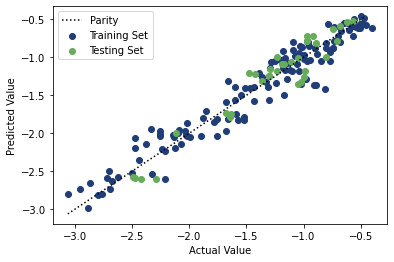

In [6]:
# Un-transform the data
train_target = target_scaler.inverse_transform(train_target)
train_predictions = target_scaler.inverse_transform(train_predictions)
test_target = target_scaler.inverse_transform(test_target)
test_predictions = target_scaler.inverse_transform(test_predictions)

# Plot the data
plt.scatter(train_target, train_predictions, c="#203d78", label="Training Set")
plt.scatter(test_target, test_predictions, c="#67ac5b", label="Testing Set")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")

# Scale the plot
target_range = (min(min(train_target), min(test_target)),
                max(max(train_target), max(test_target)))
predictions_range = (min(min(train_predictions), min(test_predictions)),
                     max(max(train_predictions), max(test_predictions)))

limits = (min(min(target_range), min(target_range)),
          max(max(predictions_range), max(predictions_range)))
plt.xlim = (limits[0], limits[1])
plt.ylim = (limits[0], limits[1])

# Draw a parity line, as a guide to the eye
plt.plot((limits[0], limits[1]), (limits[0], limits[1]), c="black", linestyle="dotted", label="Parity")
plt.legend()

# Save the figure
plt.show()